In [17]:
import akshare as ak
import json
import pandas as pd
import sys
import datetime
import os
import numpy as np
import pandas as pd
import pyecharts.options as opts
from pyecharts.charts import Line
from pyecharts.commons.utils import JsCode
from pyecharts import options as opts
from pyecharts.charts import Scatter
from pyecharts.options import InitOpts
from pyecharts import options as opts
from pyecharts.charts import Bar, Grid, Line
import matplotlib.pyplot as plt
from pyecharts import options as opts
from pyecharts.charts import Bar
%matplotlib inline


def convert_time(x):
    return str(x).replace(' 00:00:00','')
    
import re
sys.path.append('..')
from configure.settings import DBSelector
db = DBSelector()
mongo = db.mongo('qq')
fund = mongo['fund']

In [18]:
def get_net_value(code):
    '''
    获取基金的净值
    '''
    fund_open_fund_info_em_df = ak.fund_open_fund_info_em(fund=code, indicator="累计净值走势")
    return fund_open_fund_info_em_df

In [61]:
tmp_df = get_net_value('080005')

In [69]:
tmp_df.tail()

,净值日期,累计净值
3103,2022-09-07,3.403
3104,2022-09-08,3.406
3105,2022-09-09,3.421
3106,2022-09-13,3.396
3107,2022-09-14,3.377


In [3]:

def dump_mongo(df,code):
    js_str = df.to_json(orient='index')
    js_dict = json.loads(js_str)
    js_list = js_dict.values()

    fund.drop_collection(code)
    
    try:
        fund[code].insert_many(js_list)
    except Exception as e:
        print(e)


In [4]:
def start_crawl(code):
    df = get_net_value(code)
    df['净值日期']=df['净值日期'].astype(str)
    dump_mongo(df,code)


In [68]:
fund.drop_collection('080005')

{'nIndexesWas': 1, 'ns': 'fund.080005', 'ok': 1.0}

In [4]:
txt='''
1、$国泰大农业股票A(F001579)$ 基金经理程洲，今年以来回报-4.04%，近一年回报0.22%，近一年最大回撤-14.40%，二季度末规模12.87亿。

2、$银华农业产业股票(F005106)$ 基金经理唐能，今年以来回报-6.90%，近一年回报1.01%，近一年最大回撤-22.40%，二季度末规模12.78亿。

3、$前海开源沪港深农业混合（LOF）A(F164403)$ 基金经理吴国清,刘宏，今年以来回报2.97%，近一年回报8.20%，近一年最大回撤-21.68%，二季度末规模4.21亿

4、$嘉实农业产业股票(F003634)$ 基金经理吴越,朱子君，今年以来回报-7.38%，近一年回报3.37%，近一年最大回撤-19.06%，二季度末规模26.71亿。

5、$财通智慧成长混合A(F009062)$ 基金经理金梓才、钟俊，今年以来回报2.89%，近一年回报-21.17%，近一年最大回撤-30.49%，二季度末规模2.56亿。

6、$天弘中证农业主题指数A(F010769)$ 跟踪中证农业主题指数，今年以来回报-4.32%，近一年回报2.76%，近一年最大回撤-16.96%，二季度末规模2.24亿。

7、$国泰中证畜牧养殖ETF联接A(F012724)$ 跟踪中证畜牧养殖指数，今年以来回报-2.47%，近一年回报14.62%，近一年最大回撤-20.36%，二季度末规模2.38亿。

8、$华宝中证全指农牧渔指数发起式A(F013471)$ 跟踪中证全指农牧渔指数，今年以来回报-2.81%，成立以来回报1.33%，近一年最大回撤-17.85%，二季度末规模0.21亿。

9、$前海开源中证大农业指数增强A(F001027)$ 跟踪中证大农业指数，今年以来回报-10.06%，近一年回报-6.79%，近一年最大回撤-19.06%，二季度末规模6.82亿。（以上数据截至于2022年9月15日）

'''

In [19]:
code_list = re.findall('\(F(\d+)\)',txt)
fund_name = re.findall('\$(.*?)\$',txt)
fund_dict = dict(zip(code_list,fund_name))
name_list  = list(fund_dict.values())
simple_name = [i.split('(')[0] for i in name_list]

In [7]:
for code in code_list:
    start_crawl(code)

In [8]:
fund_dict

{'001579': '国泰大农业股票A(F001579)',
 '005106': '银华农业产业股票(F005106)',
 '164403': '前海开源沪港深农业混合（LOF）A(F164403)',
 '003634': '嘉实农业产业股票(F003634)',
 '009062': '财通智慧成长混合A(F009062)',
 '010769': '天弘中证农业主题指数A(F010769)',
 '012724': '国泰中证畜牧养殖ETF联接A(F012724)',
 '013471': '华宝中证全指农牧渔指数发起式A(F013471)',
 '001027': '前海开源中证大农业指数增强A(F001027)'}

In [60]:
# after fetch data

In [9]:
def plot_profit_line(df,code):
    title="{}基金收益率曲线".format(code)
    X=df['净值日期'].tolist()
    Y=list(map(lambda x:round(x,2),df['累计净值'].tolist()))
    c = (
        Line()
        .add_xaxis(X)
        .add_yaxis('', Y, is_smooth=True,
            label_opts=opts.LabelOpts(is_show=False),
            linestyle_opts=opts.LineStyleOpts(width=1,color='rgb(255, 0, 0)'),
        ).set_global_opts(
            title_opts=opts.TitleOpts(title=title),
            xaxis_opts=opts.AxisOpts(
                                    name='日期',
                                    # min_interval=5,
                                    splitline_opts=opts.SplitLineOpts(is_show=True),
                                            axislabel_opts=opts.LabelOpts(rotate=45),

                                    ),
            yaxis_opts=opts.AxisOpts(
                                    min_=min(Y),
                                    max_=max(Y),
                splitline_opts=opts.SplitLineOpts(is_show=True),
            )
                                        ).set_colors(['green'])
        .render(f"../plot_image/{title}.html")
    )

In [67]:
W=10000
focus_num = [
3.98*W,
7519,
72,
309,
]

In [17]:
c = (
    Scatter(InitOpts(width='800px',height='500px'))
    .add_xaxis(simple_name)
    .add_yaxis('A',focus_num,label_opts=opts.LabelOpts(is_show=True))
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(
                                    # name='日期',
                                    # min_interval=5,
                                    splitline_opts=opts.SplitLineOpts(is_show=True),
                                            axislabel_opts=opts.LabelOpts(rotate=-45),

                                    ),
        yaxis_opts=opts.AxisOpts(    
            min_=0,
                splitline_opts=opts.SplitLineOpts(is_show=True),
            ),
        title_opts=opts.TitleOpts(title="welcome"),
        visualmap_opts=opts.VisualMapOpts(type_="size",max_=150000, min_=2000),
    )
    .render("5fund.html")
)

In [69]:
grid = (
    Grid(init_opts=opts.InitOpts())
    .add(c, grid_opts=opts.GridOpts(pos_bottom="40%"))
    .render("grid_vertical5fund.html")
)

In [68]:

c = (
    Bar()
    .add_xaxis(
    new_name
    )
    .add_yaxis("基金关注度", focus_num,label_opts=opts.LabelOpts(is_show=True))
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=0)),
        title_opts=opts.TitleOpts(title="基金关注度"),
    )
    # .render("基金关注度.html")
)

In [65]:
new_name = []
for name in simple_name:
    new_name.append('\n'.join(list(name)))

In [73]:
new_name

['华\n安\n纳\n斯\n达\n克\n1\n0\n0\n指\n数',
 '博\n时\n标\n普\n5\n0\n0\nE\nT\nF\n联\n接',
 '天\n弘\n恒\n生\n科\n技\n指\n数\nA',
 '嘉\n实\n港\n股\n通\n新\n经\n济\n指\n数\nA',
 '华\n夏\n恒\n生\nE\nT\nF\n联\n接',
 '易\n方\n达\n中\n概\n互\n联\n5\n0\nE\nT\nF\n联\n接\n人\n民\n币\nA',
 '交\n银\n中\n证\n海\n外\n中\n国\n互\n联\n网\n指\n数',
 '华\n安\n香\n港\n精\n选',
 '中\n欧\n丰\n泓\n沪\n港\n深\nA']

In [6]:
def get_net_value_df(code):
    '''
    从mongodb获取数据
    '''
    result=[]
    for item in fund[code].find({},{'_id':0}):
        result.append(item)
    df = pd.DataFrame(result)
    return df

In [7]:
def get_year(start,end):
    '''
    获取年份
    '''
    year = (datetime.datetime.strptime(end,'%Y-%m-%d')- datetime.datetime.strptime(start,'%Y-%m-%d')).days/365
    return year

In [35]:
def get_profit_rate(df):
    '''
    计算所有的收益率
    '''
    return round((df['累计净值'].iloc[-1]-df['累计净值'].iloc[0])/df['累计净值'].iloc[0],4)

In [36]:
def get_yearly_profit_rate(df):
    '''
    计算年化收益率
    '''
    
    start = df['净值日期'].iloc[0]
    end = df['净值日期'].iloc[-1]
    year = get_year(start,end)
    print('开始时间：',start)
    print('成立年数：',round(year,2),'年')
    profit = get_profit_rate(df)
    print('成立以来累积收益率:',profit)
    year_profit = (1+profit)**(1/year)-1
    return start,round(year,4),profit,round(year_profit,4)



In [37]:

def fund_profit(code):
    '''
    生成字典
    '''

    df = get_net_value_df(code)
    max_withdraw,max_date_index = get_max_withdraw(df['累计净值'].tolist())
    start,year,profit,year_profit = get_yearly_profit_rate(df)
    d={}
    d['代码']=code
    d['名称']=fund_dict.get(code)
    d['发行日期']=start
    d['成立年数']=year
    d['累积收益率']=profit
    d['年化收益率']=year_profit
    d['最大回撤']=max_withdraw
    return d

In [20]:
def get_max_withdraw(indexs):
    max_withdraw = 0
    start_date_index =0
    max_date_index =0
    last_high = indexs[0]
    
    for index,current in enumerate(indexs):
        # 遍历所有数据
        if current>last_high:
            last_high=current
            # start_date_index=index
            continue

        if (last_high-current)/last_high>max_withdraw:
            # 找到一个最大值时，保存其位置
            max_withdraw = (last_high-current)/last_high
            max_date_index=index

    return max_withdraw,max_date_index # 变成百分比

In [38]:
result = []
for code in code_list:
    d = fund_profit(code)
    result.append(d)

开始时间： 2017-06-15
成立年数： 5.27 年
成立以来累积收益率: 1.2848
开始时间： 2017-09-28
成立年数： 4.99 年
成立以来累积收益率: 0.988
开始时间： 2015-06-04
成立年数： 7.31 年
成立以来累积收益率: 0.5056
开始时间： 2016-12-07
成立年数： 5.79 年
成立以来累积收益率: 0.9959
开始时间： 2020-04-03
成立年数： 2.47 年
成立以来累积收益率: 0.4356
开始时间： 2021-01-22
成立年数： 1.67 年
成立以来累积收益率: -0.1117
开始时间： 2021-07-02
成立年数： 1.22 年
成立以来累积收益率: -0.0134
开始时间： 2021-12-06
成立年数： 0.79 年
成立以来累积收益率: -0.0441
开始时间： 2015-02-13
成立年数： 7.61 年
成立以来累积收益率: 0.2123


In [39]:
df = pd.DataFrame(result)

In [23]:
df.head(20)

,代码,名称,发行日期,成立年数,累积收益率,年化收益率,最大回撤
0,001579,国泰大农业股票A(F001579),2017-06-15,5.27,1.28,0.17,0.233251
1,005106,银华农业产业股票(F005106),2017-09-28,4.99,0.99,0.15,0.314755
2,164403,前海开源沪港深农业混合（LOF）A(F164403),2015-06-04,7.31,0.51,0.06,0.310622
3,003634,嘉实农业产业股票(F003634),2016-12-07,5.79,1.00,0.13,0.331582
4,009062,财通智慧成长混合A(F009062),2020-04-03,2.47,0.44,0.16,0.304863
5,010769,天弘中证农业主题指数A(F010769),2021-01-22,1.67,-0.11,-0.07,0.267140
6,012724,国泰中证畜牧养殖ETF联接A(F012724),2021-07-02,1.22,-0.01,-0.01,0.203638
7,013471,华宝中证全指农牧渔指数发起式A(F013471),2021-12-06,0.79,-0.04,-0.05,0.178454
8,001027,前海开源中证大农业指数增强A(F001027),2015-02-13,7.61,0.21,0.03,0.426704


In [40]:
df['累积收益率']=df['累积收益率'].map(lambda x:x*100)
df['年化收益率']=df['年化收益率'].map(lambda x:x*100)
df['最大回撤']=df['最大回撤'].map(lambda x:x*100)


In [41]:
df.sort_values('年化收益率',ascending=False).head(10).to_excel('农业基金1.xlsx',encoding='utf8')

In [16]:
import pandas as pd

result = pd.DataFrame()

for code in code_list:
    df_ = get_net_value_df(code)
    df_=df_.rename(columns={'累计净值':code})
    # del df_['日增长率']
    df_['净值日期']=pd.to_datetime(df_['净值日期'],format='%Y-%m-%d')
    df_=df_.set_index('净值日期',drop=True)
    # result.append(df)
    if len(result)==0:
        result=df_

    else:
        result = pd.merge(result,df_,how='outer',left_index=True,right_index=True)


    

In [13]:
result.head()

,001579,005106,164403,003634,009062,010769,012724,013471,001027
净值日期,,,,,,,,,
2015-02-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000
2015-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000
2015-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000
2015-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000
2015-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.001


In [116]:
result_na = result.dropna(axis=0)

In [117]:
result_na

,501059,005561,161907,501029,008928,004814,005618,080005,008163,006658,007751
净值日期,,,,,,,,,,,
2020-03-26,1.1887,0.9410,1.5528,0.9509,1.0000,0.9751,1.2679,2.259,0.9479,0.8612,0.8928
2020-03-27,1.1980,0.9466,1.5635,0.9575,1.0000,0.9736,1.2698,2.270,0.9545,0.8730,0.8982
2020-04-03,1.1924,0.9388,1.5460,0.9491,1.0009,0.9630,1.2807,2.255,0.9452,0.8726,0.8958
2020-04-10,1.2077,0.9481,1.5605,0.9581,1.0020,0.9927,1.3136,2.268,0.9489,0.9024,0.9159
2020-04-17,1.2248,0.9554,1.5673,0.9597,0.9952,0.9991,1.3511,2.276,0.9551,0.9073,0.9194
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-07,2.1560,1.6545,2.3772,1.4053,1.7948,1.6858,1.9841,3.403,1.2283,0.7869,1.1436
2022-09-08,2.1521,1.6565,2.3692,1.4008,1.7672,1.6806,1.9775,3.406,1.2301,0.7739,1.1432
2022-09-09,2.1821,1.6753,2.3913,1.4152,1.7658,1.7137,1.9793,3.421,1.2408,0.7921,1.1537


In [109]:
profit_df = pd.DataFrame(result)

In [110]:
profit_df['最大回撤']=profit_df['最大回撤'].map(lambda x:round(x*100,2))
profit_df['累积收益率']=profit_df['累积收益率'].map(lambda x:round(x*100,2))
profit_df['年化收益率']=profit_df['年化收益率'].map(lambda x:round(x*100,2))


In [111]:
profit_df.head(20)

,代码,名称,发行日期,成立年数,累积收益率,年化收益率,最大回撤
0,501059,西部利得国企红利指数增强A(F501059),2018-07-11,4.18,115.0,20.0,19.28
1,005561,创金合信中证红利低波动指数A(F005561),2018-04-26,4.39,65.0,12.0,19.74
2,161907,万家中证红利指数(LOF)A(F161907),2011-03-17,11.50,136.0,8.0,46.84
3,501029,华宝红利基金(F501029),2017-01-18,5.66,40.0,6.0,28.74
4,008928,泰达消费红利指数A(F008928),2020-03-26,2.47,76.0,26.0,18.13
5,004814,中欧红利优享混合A(F004814),2018-04-19,4.41,69.0,13.0,25.26
6,005618,融通红利机会混合A(F005618),2018-03-27,4.47,98.0,17.0,15.30
7,080005,长盛量化红利混合(F080005),2009-11-25,12.81,238.0,10.0,53.00
8,008163,南方大盘红利低波50ETF联接A(F008163),2020-01-21,2.65,23.0,8.0,12.26
9,006658,财通中证香港红利等权指数A(F006658),2019-04-26,3.39,-21.0,-7.0,29.02


In [112]:
profit_df.sort_values(by='年化收益率',ascending=False).head(20)

,代码,名称,发行日期,成立年数,累积收益率,年化收益率,最大回撤
4,008928,泰达消费红利指数A(F008928),2020-03-26,2.47,76.0,26.0,18.13
0,501059,西部利得国企红利指数增强A(F501059),2018-07-11,4.18,115.0,20.0,19.28
6,005618,融通红利机会混合A(F005618),2018-03-27,4.47,98.0,17.0,15.30
5,004814,中欧红利优享混合A(F004814),2018-04-19,4.41,69.0,13.0,25.26
1,005561,创金合信中证红利低波动指数A(F005561),2018-04-26,4.39,65.0,12.0,19.74
7,080005,长盛量化红利混合(F080005),2009-11-25,12.81,238.0,10.0,53.00
2,161907,万家中证红利指数(LOF)A(F161907),2011-03-17,11.50,136.0,8.0,46.84
8,008163,南方大盘红利低波50ETF联接A(F008163),2020-01-21,2.65,23.0,8.0,12.26
3,501029,华宝红利基金(F501029),2017-01-18,5.66,40.0,6.0,28.74
10,007751,景顺长城中证沪港深红利低波A(F007751),2019-09-06,3.02,14.0,4.0,19.54


In [25]:
profit_df.to_excel('fund红利.xlsx',encoding='utf8')

In [22]:
code_list[0]

'001594'

In [81]:
def automatic_investment_plan(code):
    '''
    定投收益
    '''
    df = get_net_value_df(code)

    money = 10000
    total_share =0 
    interval = 22
    length = len(df)
    sum_money=0
    count=0
    for i in range(0,length,interval):
        buy_date_df = df.iloc[i]
        share = money/buy_date_df['单位净值']
        total_share+=share
        sum_money+=money
        count+=1
    virtual_profit = (df.iloc[-1]['单位净值']*total_share-sum_money)/sum_money
    data=[]
    year,month,day=df.iloc[0]['净值日期'].split('-')
    for i in range(count):
        data.append((datetime.date(int(year), int(month), int(day))+datetime.timedelta(days=i*30), -1*money))
    current_money = df.iloc[-1]['单位净值']*total_share
    data.append((datetime.date(int(year), int(month), int(day))+datetime.timedelta(days=i*30),current_money))
    percent = xirr(data)
    every_round_profit = irr([money]*count+[-1*current_money])
    real_profit = pow(every_round_profit+1,count)-1
    return code,sum_money,round(current_money,2),round(percent,4),round(virtual_profit,4),round(real_profit,4)

In [82]:
def xirr(cashflows):
    # 函数
    years = [(ta[0] - cashflows[0][0]).days / 365. for ta in cashflows]
    residual = 1.0
    step = 0.05
    guess = 0.05
    epsilon = 0.0001
    limit = 10000
    while abs(residual) > epsilon and limit > 0:
        limit -= 1
        residual = 0.0
        for i, trans in enumerate(cashflows):
            residual += trans[1] / pow(guess, years[i])
        if abs(residual) > epsilon:
            if residual > 0:
                guess += step
            else:
                guess -= step
                step /= 2.0
    return guess - 1


In [ ]:
# 测试
data = [(datetime.date(2006, 1, 24), -39967), (datetime.date(2008, 2, 6), -19866), (datetime.date(2010, 10, 18), 245706), (datetime.date(2013, 9, 14), 52142)]
xirr(data)

In [56]:
result =[]
for code in code_list:
    d={}
    code,sum_money,current_money,percent,virtual_profit,real_profit=automatic_investment_plan(code)
    d['代码']=code
    d['投入总金额']=sum_money
    d['目前总金额']=current_money
    d['总收益']=percent
    d['简单收益率']=virtual_profit
    d['irr收益率']=real_profit
    result.append(d)
df = pd.DataFrame(result)


740000 891983.51
001594 0.06 0.21 0.43
740000 838011.42
502010 0.04 0.13 0.27
730000 548702.23
167301 -0.1 -0.25 -0.45
60000 62541.56
013273 0.22 0.04 0.07
140000 138765.67
010696 -0.02 -0.01 -0.02


In [53]:
df.head()

,代码,投入总金额,目前总金额,总收益,简单收益率,irr收益率
0,001594,740000,891983.51,0.06,20.54,0.43
1,502010,740000,838011.42,0.04,13.24,0.27
2,167301,730000,548702.23,-0.10,-24.84,-0.45
3,013273,60000,62541.56,0.22,4.24,0.07
4,010696,140000,138765.67,-0.02,-0.88,-0.02


In [57]:
df.to_excel('定投.xlsx',encoding='utf8')

In [83]:
def irr(values):
    """
    Return the Internal Rate of Return (IRR).
    .. deprecated:: 1.18
       `irr` is deprecated; for details, see NEP 32 [1]_.
       Use the corresponding function in the numpy-financial library,
       https://pypi.org/project/numpy-financial.
    This is the "average" periodically compounded rate of return
    that gives a net present value of 0.0; for a more complete explanation,
    see Notes below.
    :class:`decimal.Decimal` type is not supported.
    Parameters
    ----------
    values : array_like, shape(N,)
        Input cash flows per time period.  By convention, net "deposits"
        are negative and net "withdrawals" are positive.  Thus, for
        example, at least the first element of `values`, which represents
        the initial investment, will typically be negative.
    Returns
    -------
    out : float
        Internal Rate of Return for periodic input values.
    Notes
    -----
    The IRR is perhaps best understood through an example (illustrated
    using np.irr in the Examples section below).  Suppose one invests 100
    units and then makes the following withdrawals at regular (fixed)
    intervals: 39, 59, 55, 20.  Assuming the ending value is 0, one's 100
    unit investment yields 173 units; however, due to the combination of
    compounding and the periodic withdrawals, the "average" rate of return
    is neither simply 0.73/4 nor (1.73)^0.25-1.  Rather, it is the solution
    (for :math:`r`) of the equation:
    .. math:: -100 + \\frac{39}{1+r} + \\frac{59}{(1+r)^2}
     + \\frac{55}{(1+r)^3} + \\frac{20}{(1+r)^4} = 0
    In general, for `values` :math:`= [v_0, v_1, ... v_M]`,
    irr is the solution of the equation: [2]_
    .. math:: \\sum_{t=0}^M{\\frac{v_t}{(1+irr)^{t}}} = 0
    References
    ----------
    .. [1] NumPy Enhancement Proposal (NEP) 32,
       https://numpy.org/neps/nep-0032-remove-financial-functions.html
    .. [2] L. J. Gitman, "Principles of Managerial Finance, Brief," 3rd ed.,
       Addison-Wesley, 2003, pg. 348.
    Examples
    --------
    >>> round(np.irr([-100, 39, 59, 55, 20]), 5)
    0.28095
    >>> round(np.irr([-100, 0, 0, 74]), 5)
    -0.0955
    >>> round(np.irr([-100, 100, 0, -7]), 5)
    -0.0833
    >>> round(np.irr([-100, 100, 0, 7]), 5)
    0.06206
    >>> round(np.irr([-5, 10.5, 1, -8, 1]), 5)
    0.0886
    """
    # `np.roots` call is why this function does not support Decimal type.
    #
    # Ultimately Decimal support needs to be added to np.roots, which has
    # greater implications on the entire linear algebra module and how it does
    # eigenvalue computations.
    res = np.roots(values[::-1])  # 求根，对于n次多项式，p[0] * x**n + p[1] * x**(n-1) + ... + p[n-1]*x + p[n]，传入p的列表参数[p[0],p[1],...p[n]].
    mask = (res.imag == 0) & (res.real > 0)  # 虚部为0，实部为非负数。
    if not mask.any():  # 判断是否有满足条件的实根
        return np.nan  # 不满足，返回Not A Number
    res = res[mask].real
    # NPV(rate) = 0 can have more than one solution so we return
    # only the solution closest to zero.
    rate = 1/res - 1  # 这里解出的res，也就是符合条件的x，其实等于1/(1+r)，因此要做一个变换回去，r=1/x-1
    rate = rate.item(np.argmin(np.abs(rate)))  # argmin()取最小值的下标，也就是说可能会计算出多个折现率，我们取最小那个
    return rate

In [1]:
import requests

headers = {
    'authority': 'api.jiucaishuo.com',
    'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="98", "Google Chrome";v="98"',
    'accept': 'application/json, text/plain, */*',
    'content-type': 'application/json;charset=UTF-8',
    'sec-ch-ua-mobile': '?0',
    'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36',
    'sec-ch-ua-platform': '"Linux"',
    'origin': 'https://www.funddb.cn',
    'sec-fetch-site': 'cross-site',
    'sec-fetch-mode': 'cors',
    'sec-fetch-dest': 'empty',
    'accept-language': 'zh,en;q=0.9,en-US;q=0.8,zh-CN;q=0.7',
}

data = '{"code":"013273","category":"wind_category","date":"","type":"pc","data_source":"xichou","version":"1.8.9","authtoken":"","act_time":1645634683356,"tirgkjfs":"fb","abiokytke":"52","u54rg5d":"76","kf54ge7":"f","tiklsktr4":"b","lksytkjh":"0ba1","sbnoywr":"27","bgd7h8tyu54":"46","y654b5fs3tr":"d","bioduytlw":"6","bd4uy742":"4","h67456y":"70b","bvytikwqjk":"46","ngd4uy551":"0b","bgiuytkw":"bc","nd354uy4752":"4","ghtoiutkmlg":"db8","bd24y6421f":"7e","tbvdiuytk":"7","ibvytiqjek":"1d","jnhf8u5231":"bc","fjlkatj":"760","hy5641d321t":"e4","iogojti":"e","ngd4yut78":"b8","nkjhrew":"4","yt447e13f":"1","n3bf4uj7y7":"b","nbf4uj7y432":"52","yi854tew":"54","h13ey474":"54f","quikgdky":"c3"}'

response = requests.post('https://api.jiucaishuo.com/v2/fund-lists/fundinvest', headers=headers, data=data)

In [4]:
result = response.json()

In [ ]:
result['data']['gp']['list']

In [11]:
def read_data_from_mongo(code):
    result=[]
    for item in fund[code].find():
        result.append(item)

    df = pd.DataFrame(result)
    return df

In [7]:
df = read_data_from_mongo(code_list[0])

In [8]:
df.head()

,_id,净值日期,单位净值,日增长率
0,621659cc28d482b10a0e5c05,2015-07-08,1.0000,0.0000
1,621659cc28d482b10a0e5c06,2015-07-10,1.0815,0.0000
2,621659cc28d482b10a0e5c07,2015-07-13,1.0514,-2.7832
3,621659cc28d482b10a0e5c08,2015-07-14,1.0324,-1.8071
4,621659cc28d482b10a0e5c09,2015-07-15,1.0498,1.6854


In [ ]:
c = (
    Scatter(InitOpts(width='800px',height='500px'))
    .add_xaxis(simple_name)
    .add_yaxis('A',focus_num,label_opts=opts.LabelOpts(is_show=True))
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(
                                    # name='日期',
                                    # min_interval=5,
                                    splitline_opts=opts.SplitLineOpts(is_show=True),
                                            axislabel_opts=opts.LabelOpts(rotate=-45),

                                    ),
        yaxis_opts=opts.AxisOpts(    
            min_=0,
                splitline_opts=opts.SplitLineOpts(is_show=True),
            ),
        title_opts=opts.TitleOpts(title="红利基金收益率曲线"),
        visualmap_opts=opts.VisualMapOpts(type_="size",max_=150000, min_=2000),
    )
    .render("../plot_image/红利.html")
)

In [ ]:
# 3曲线
from datetime import datetime

name = datetime.now().strftime('%Y%m%d')

X=df.index.tolist()
X=list(map(convert_time,X))
Y=df['收益率'].map(lambda x:round(x,0)).tolist()
Y2=df2['收益率'].map(lambda x:round(x,0)).tolist()
Y3=df3['收益率'].map(lambda x:round(x,0)).tolist()
title="低溢价"
title2="双低"
title3='低价'

full_title = '2022年 低溢价，双低，低价[10只，5天轮]'
full_title1 = '低溢价，双低，低价收益率【10只，5天轮动】'

types=full_title1
y_min = min(min(min(Y),min(Y2)),min(Y3))
y_max = max(max(max(Y),max(Y2)),max(Y3))

c = (
    Line()
    .add_xaxis(X)
    .add_yaxis(title, Y, is_smooth=True,
    label_opts=opts.LabelOpts(is_show=False),
linestyle_opts=opts.LineStyleOpts(width=2,color='rgb(255, 0, 0)'),
    ).add_yaxis(title2, Y2, is_smooth=True,
linestyle_opts=opts.LineStyleOpts(width=2,color='rgb(0, 0, 255)'),
label_opts=opts.LabelOpts(is_show=False),
    ).add_yaxis(title3, Y3, is_smooth=True,
linestyle_opts=opts.LineStyleOpts(width=2,color='rgb(0, 255, 0)'),
label_opts=opts.LabelOpts(is_show=False),
    ).set_global_opts(
        title_opts=opts.TitleOpts(title=full_title),
        xaxis_opts=opts.AxisOpts(
                                name='日期',
                                min_interval=1,
                                splitline_opts=opts.SplitLineOpts(is_show=True),
           axislabel_opts=opts.LabelOpts(rotate=55),
                                ),
        yaxis_opts=opts.AxisOpts(name='收益率%',
                                interval=3,
                                 min_=y_min-2,
                                 max_=y_max+2,
            splitline_opts=opts.SplitLineOpts(is_show=True),
        )
                                    )
                                    .set_colors(['red','blue','green']) # 点的颜色
    .render(f"../plot_image/多曲线plot_line_{name}_{types}_{date}_{rotation_rate}.html")
)

In [ ]:
c = (
    Line()
    .add_xaxis(X)
    .add_yaxis(title, Y, is_smooth=True,
    label_opts=opts.LabelOpts(is_show=False),
linestyle_opts=opts.LineStyleOpts(width=2,color='rgb(255, 0, 0)'),
    ).add_yaxis(title2, Y2, is_smooth=True,
linestyle_opts=opts.LineStyleOpts(width=2,color='rgb(0, 0, 255)'),
label_opts=opts.LabelOpts(is_show=False),
    ).add_yaxis(title3, Y3, is_smooth=True,
linestyle_opts=opts.LineStyleOpts(width=2,color='rgb(0, 255, 0)'),
label_opts=opts.LabelOpts(is_show=False),
    ).set_global_opts(
        title_opts=opts.TitleOpts(title=full_title),
        xaxis_opts=opts.AxisOpts(
                                name='日期',
                                min_interval=1,
                                splitline_opts=opts.SplitLineOpts(is_show=True),
           axislabel_opts=opts.LabelOpts(rotate=55),
                                ),
        yaxis_opts=opts.AxisOpts(name='收益率%',
                                interval=3,
                                 min_=y_min-2,
                                 max_=y_max+2,
            splitline_opts=opts.SplitLineOpts(is_show=True),
        )
                                    )
                                    .set_colors(['red','blue','green']) # 点的颜色
    .render(f"../plot_image/多曲线plot_line_{name}_{types}_{date}_{rotation_rate}.html")
)

In [118]:
c=Line()


In [119]:
X=result_na.index.tolist()
X=list(map(lambda x:x.strftime('%Y-%m-%d'),X))
c=c.add_xaxis(X)

In [120]:

for code,name in fund_dict.items():
    Y=result_na[code].tolist()
    c=c.add_yaxis(name, Y, is_smooth=True,
    label_opts=opts.LabelOpts(is_show=False),
linestyle_opts=opts.LineStyleOpts(width=1,color='rgb(255, 0, 0)'),
    )

In [31]:
c.set_global_opts(
        title_opts=opts.TitleOpts(title='ddddd'),
        xaxis_opts=opts.AxisOpts(
                                name='日期',
                                # min_interval=1,
                                splitline_opts=opts.SplitLineOpts(is_show=True),
           axislabel_opts=opts.LabelOpts(rotate=55),
                                ),
        yaxis_opts=opts.AxisOpts(name='收益率%',
                                # interval=3,
                                 min_=0.6,
                                 max_=2.8,
            splitline_opts=opts.SplitLineOpts(is_show=True),
        )
                                    ).set_colors(['red','blue','green']) # 点的颜色


In [32]:
c.render(f"../plot_image/多曲线plot_line_1111223.html")


'/home/xda/github/stock/plot_image/多曲线plot_line_1111223.html'

In [121]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [125]:
result_na.head()


,501059,005561,161907,501029,008928,004814,005618,080005,008163,006658,007751
净值日期,,,,,,,,,,,
2020-03-26,1.1887,0.9410,1.5528,0.9509,1.0000,0.9751,1.2679,2.259,0.9479,0.8612,0.8928
2020-03-27,1.1980,0.9466,1.5635,0.9575,1.0000,0.9736,1.2698,2.270,0.9545,0.8730,0.8982
2020-04-03,1.1924,0.9388,1.5460,0.9491,1.0009,0.9630,1.2807,2.255,0.9452,0.8726,0.8958
2020-04-10,1.2077,0.9481,1.5605,0.9581,1.0020,0.9927,1.3136,2.268,0.9489,0.9024,0.9159
2020-04-17,1.2248,0.9554,1.5673,0.9597,0.9952,0.9991,1.3511,2.276,0.9551,0.9073,0.9194


In [138]:
new_df = result_na.copy()

In [127]:
base=new_df.iloc[0]

In [128]:
base['501059']

1.1887

In [139]:
def convert(x,code):
    b=base[code]
    return x/b

In [140]:
for code,name in fund_dict.items():
    new_df['{}'.format(code)]=new_df[code].apply(convert,args=(code,))


In [141]:
new_df.head()

,501059,005561,161907,501029,008928,004814,005618,080005,008163,006658,007751
净值日期,,,,,,,,,,,
2020-03-26,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-03-27,1.007824,1.005951,1.006891,1.006941,1.0000,0.998462,1.001499,1.004869,1.006963,1.013702,1.006048
2020-04-03,1.003113,0.997662,0.995621,0.998107,1.0009,0.987591,1.010095,0.998229,0.997152,1.013237,1.003360
2020-04-10,1.015984,1.007545,1.004959,1.007572,1.0020,1.018049,1.036044,1.003984,1.001055,1.047840,1.025874
2020-04-17,1.030369,1.015303,1.009338,1.009254,0.9952,1.024613,1.065620,1.007525,1.007596,1.053530,1.029794


In [144]:
result_na1=new_df.rename(columns=fund_dict)

In [148]:
plt.rcParams['figure.figsize'] = (16.0, 10)

<AxesSubplot:xlabel='净值日期'>

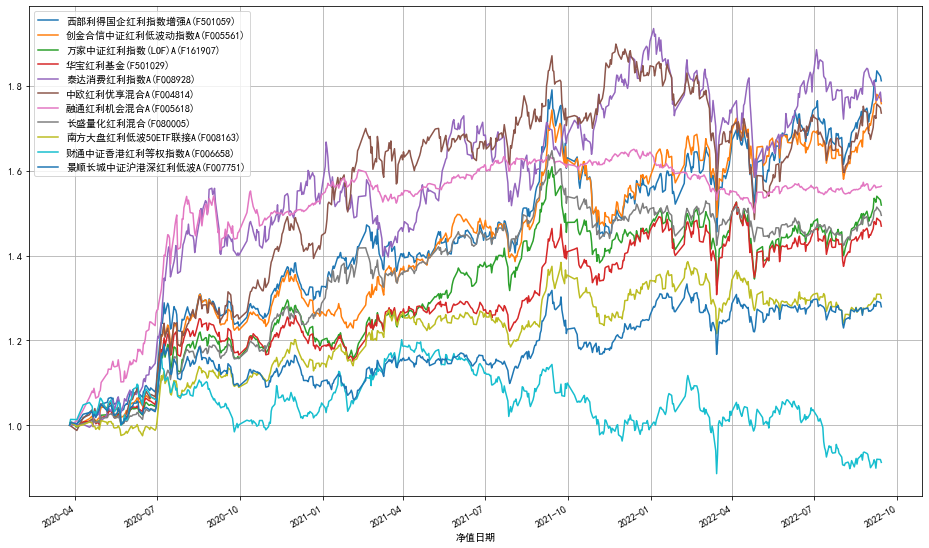

In [149]:
# plt.figure(figsize=(8,8))

result_na1.plot(grid=True,)
# plt.show()


In [14]:
for code,name in fund_dict.items():
    result = []
    for item in fund[code].find({},{'_id':0}):
        result.append(item)
    df = pd.DataFrame(result)
    plot_profit_line(df,name)

In [30]:
fund_dict

{'001579': '国泰大农业股票A(F001579)',
 '005106': '银华农业产业股票(F005106)',
 '164403': '前海开源沪港深农业混合（LOF）A(F164403)',
 '003634': '嘉实农业产业股票(F003634)',
 '009062': '财通智慧成长混合A(F009062)',
 '010769': '天弘中证农业主题指数A(F010769)',
 '012724': '国泰中证畜牧养殖ETF联接A(F012724)',
 '013471': '华宝中证全指农牧渔指数发起式A(F013471)',
 '001027': '前海开源中证大农业指数增强A(F001027)'}

In [22]:
import akshare as ak
def get_holding_list(code,year):
    fund_portfolio_hold_em_df = ak.fund_portfolio_hold_em(code=code, year=year)
    return fund_portfolio_hold_em_df[fund_portfolio_hold_em_df['季度']=='2022年2季度股票投资明细']

In [20]:

code='501059'
holding_dict[code] = get_holding_list(code,2022)

In [23]:
stock_list = holding_dict[code]['股票名称'].tolist()

In [24]:
holding_dict={}
for code,name in fund_dict.items():
    holding_dict[code] = get_holding_list(code,2022)

In [31]:
holding_dict['001579']

,序号,股票代码,股票名称,占净值比例,持股数,持仓市值,季度
0,1,600438,通威股份,6.50,140.00,8380.40,2022年2季度股票投资明细
1,2,300498,温氏股份,6.29,380.85,8108.40,2022年2季度股票投资明细
2,3,000902,新洋丰,5.44,415.00,7009.35,2022年2季度股票投资明细
3,4,002714,牧原股份,5.43,126.55,6994.32,2022年2季度股票投资明细
4,5,002250,联化科技,5.08,400.00,6548.00,2022年2季度股票投资明细
...,...,...,...,...,...,...,...
123,124,001268,联合精密,0.00,0.04,1.13,2022年2季度股票投资明细
124,125,301111,粤万年青,0.00,0.04,1.04,2022年2季度股票投资明细
125,126,301138,华研精机,0.00,0.03,0.88,2022年2季度股票投资明细
126,127,301158,德石股份,0.00,0.04,0.77,2022年2季度股票投资明细


In [25]:
stock_lists = []
for code,holding in holding_dict.items():
    stock_list = holding['股票名称'].tolist()
    stock_lists.extend(stock_list)

In [37]:
for code,holding in holding_dict.items():
    x=holding['股票名称'].tolist()
    
    if '贵州茅台' not in x:
        print(code)


003634
009062
010769
012724
013471


In [26]:
count_dict ={}
for i in stock_lists:
    count_dict.setdefault(i,0)
    count_dict[i]+=1

In [27]:
holding_ordered = sorted(count_dict.items(),key=lambda x:x[1],reverse=True)

In [28]:
len(stock_lists)

724

In [29]:
for  i in holding_ordered:
    if i[1]>4:
        print(i[0],i[1])

温氏股份 9
牧原股份 9
大北农 8
新希望 7
苏垦农发 7
益客食品 7
天康生物 7
海大集团 6
隆平高科 6
登海种业 6
凌云光 6
泰恩康 6
腾远钴业 6
唐人神 6
天邦食品 6
荃银高科 5
华如科技 5
中科环保 5
欧圣电气 5
中科江南 5
普瑞眼科 5
何氏眼科 5
奕东电子 5
唯科科技 5
瑞德智能 5
金道科技 5
华兰疫苗 5
佳缘科技 5
德石股份 5
巨星农牧 5
傲农生物 5
立华股份 5


In [38]:
import akshare as ak
stock_board_industry_name_em_df = ak.stock_board_industry_name_em()
print(stock_board_industry_name_em_df)

    排名   板块名称    板块代码       最新价     涨跌额   涨跌幅            总市值   换手率  上涨家数  \
0    1     银行  BK0475   2839.26    6.87  0.24  9210124800000  0.18    21   
1    2     保险  BK0474    923.59   -0.97 -0.10  2254888784000  0.19     4   
2    3  房地产服务  BK1045    991.49   -2.02 -0.20    94682094000  1.94     4   
3    4  房地产开发  BK0451  14824.42  -42.02 -0.28  1642808944000  1.54    30   
4    5   航空机场  BK0420   4611.40  -22.44 -0.48   707478976000  0.19     2   
..  ..    ...     ...       ...     ...   ...            ...   ...   ...   
81  82    小金属  BK1027   1673.89  -88.67 -5.03   687335856000  1.24     0   
82  83   电源设备  BK1034   1732.54 -100.87 -5.50   347626608000  2.59     1   
83  84     电池  BK1033   1345.50  -82.65 -5.79  2340658592000  1.98     1   
84  85   风电设备  BK1032   1345.77  -90.38 -6.29   384221728000  1.60     0   
85  86   光伏设备  BK1031   1946.03 -167.81 -7.94  2395664352000  2.15     0   

    下跌家数  领涨股票  领涨股票-涨跌幅  
0     12  招商银行      2.67  
1      2  中国平安      0.76  
2     

In [39]:
bk_name = stock_board_industry_name_em_df['板块名称'].tolist()

In [40]:
bk_name[0]

'银行'

In [43]:
import akshare as ak
bk_result ={}
for bk in bk_name:
    stock_board_industry_cons_em_df = ak.stock_board_industry_cons_em(symbol=bk)
    st_name =stock_board_industry_cons_em_df['名称'].tolist()
    # st=['']
    bk_result[bk]=st_name

In [ ]:
stock_board_industry_cons_em_df

In [46]:
belongs={}
for i in holding_ordered:
    for k,v in bk_result.items():
        if i[0] in v:
            belongs[i[0]]=k
            break


In [47]:
belongs

{'南京银行': '银行',
 '中国神华': '煤炭行业',
 '中南传媒': '文化传媒',
 '福元医药': '化学制药',
 '联合精密': '通用设备',
 '中国建筑': '工程建设',
 '保利发展': '房地产开发',
 '交通银行': '银行',
 '中国银行': '银行',
 '工商银行': '银行',
 '中信银行': '银行',
 '光大银行': '银行',
 '江苏银行': '银行',
 '兴业银行': '银行',
 '华发股份': '房地产开发',
 '唐山港': '航运港口',
 '洪城环境': '公用事业',
 '海螺水泥': '水泥建材',
 '申能股份': '电力行业',
 '凌云光': '专用设备',
 '北京银行': '银行',
 '农业银行': '银行',
 '建设银行': '银行',
 '雅戈尔': '纺织服装',
 '诚达药业': '医疗服务',
 '唯科科技': '塑料制品',
 '建发股份': '贸易行业',
 '兖矿能源': '煤炭行业',
 '天健集团': '工程建设',
 '平煤股份': '煤炭行业',
 '厦门象屿': '物流行业',
 '南京高科': '房地产开发',
 '中国石化': '石油行业',
 '山东高速': '铁路公路',
 '大秦铁路': '物流行业',
 '青岛港': '航运港口',
 '宁夏建材': '水泥建材',
 '元道通信': '通信服务',
 '超卓航科': '航天航空',
 '盛帮股份': '橡胶制品',
 '元祖股份': '食品饮料',
 '长江电力': '电力行业',
 '梅花生物': '食品饮料',
 '华兰疫苗': '生物制品',
 '星辉环材': '化学原料',
 '奕东电子': '消费电子',
 '华康医疗': '医疗服务',
 '标榜股份': '汽车零部件',
 '邮储银行': '银行',
 '陕西煤业': '煤炭行业',
 '安徽建工': '工程建设',
 '冀中能源': '煤炭行业',
 '招商蛇口': '房地产开发',
 '深高速': '铁路公路',
 '华电国际': '电力行业',
 '隧道股份': '工程建设',
 '凤凰传媒': '文化传媒',
 '淮北矿业': '煤炭行业',
 '招商银行': '银行',
 '广汇能源': '石油行业',
 '中国船舶

In [48]:
result_={}
for k,v in belongs.items():
    result_.setdefault(v,0)
    result_[v]+=1

In [49]:
result_

{'银行': 33,
 '煤炭行业': 15,
 '文化传媒': 9,
 '化学制药': 7,
 '通用设备': 12,
 '工程建设': 12,
 '房地产开发': 15,
 '航运港口': 8,
 '公用事业': 5,
 '水泥建材': 7,
 '电力行业': 13,
 '专用设备': 18,
 '纺织服装': 12,
 '医疗服务': 8,
 '塑料制品': 5,
 '贸易行业': 3,
 '物流行业': 7,
 '石油行业': 5,
 '铁路公路': 5,
 '通信服务': 5,
 '航天航空': 2,
 '橡胶制品': 3,
 '食品饮料': 19,
 '生物制品': 7,
 '化学原料': 14,
 '消费电子': 8,
 '汽车零部件': 14,
 '船舶制造': 1,
 '证券': 8,
 '环保行业': 11,
 '软件开发': 14,
 '多元金融': 2,
 '装修建材': 5,
 '医疗器械': 7,
 '能源金属': 2,
 '电子元件': 6,
 '小金属': 6,
 '商业百货': 4,
 '钢铁行业': 10,
 '酿酒行业': 7,
 '农药兽药': 6,
 '有色金属': 6,
 '化学制品': 15,
 '交运设备': 3,
 '汽车服务': 2,
 '保险': 3,
 '汽车整车': 5,
 '工程机械': 4,
 '医药商业': 4,
 '专业服务': 3,
 '农牧饲渔': 11,
 '半导体': 11,
 '电网设备': 7,
 '电池': 5,
 '互联网服务': 3,
 '通信设备': 5,
 '贵金属': 5,
 '非金属材料': 2,
 '光伏设备': 7,
 '化肥行业': 2,
 '旅游酒店': 2,
 '包装材料': 3,
 '仪器仪表': 2,
 '中药': 7,
 '家电行业': 7,
 '房地产服务': 1,
 '玻璃玻纤': 4,
 '装修装饰': 2,
 '风电设备': 1,
 '电子化学品': 1,
 '化纤行业': 3,
 '电源设备': 1,
 '美容护理': 1,
 '采掘行业': 1,
 '光学光电子': 2,
 '航空机场': 1,
 '家用轻工': 2,
 '工程咨询服务': 2,
 '珠宝首饰': 2,
 '计算机设备': 2}

In [50]:
result_industry = sorted(result_.items(),key=lambda x:x[1],reverse=True)

In [52]:
for i in result_industry:
    print(i[0],i[1])

银行 33
食品饮料 19
专用设备 18
煤炭行业 15
房地产开发 15
化学制品 15
化学原料 14
汽车零部件 14
软件开发 14
电力行业 13
通用设备 12
工程建设 12
纺织服装 12
环保行业 11
农牧饲渔 11
半导体 11
钢铁行业 10
文化传媒 9
航运港口 8
医疗服务 8
消费电子 8
证券 8
化学制药 7
水泥建材 7
物流行业 7
生物制品 7
医疗器械 7
酿酒行业 7
电网设备 7
光伏设备 7
中药 7
家电行业 7
电子元件 6
小金属 6
农药兽药 6
有色金属 6
公用事业 5
塑料制品 5
石油行业 5
铁路公路 5
通信服务 5
装修建材 5
汽车整车 5
电池 5
通信设备 5
贵金属 5
商业百货 4
工程机械 4
医药商业 4
玻璃玻纤 4
贸易行业 3
橡胶制品 3
交运设备 3
保险 3
专业服务 3
互联网服务 3
包装材料 3
化纤行业 3
航天航空 2
多元金融 2
能源金属 2
汽车服务 2
非金属材料 2
化肥行业 2
旅游酒店 2
仪器仪表 2
装修装饰 2
光学光电子 2
家用轻工 2
工程咨询服务 2
珠宝首饰 2
计算机设备 2
船舶制造 1
房地产服务 1
风电设备 1
电子化学品 1
电源设备 1
美容护理 1
采掘行业 1
航空机场 1


In [54]:
len(holding_dict)

11

In [55]:
type(holding_dict)

dict

In [56]:
holding_dict

{'501059':       序号    股票代码  股票名称  占净值比例     持股数     持仓市值              季度
 0      1  601658  邮储银行   4.01  315.93  1702.86  2022年2季度股票投资明细
 1      2  600919  江苏银行   3.99  238.16  1695.71  2022年2季度股票投资明细
 2      3  601166  兴业银行   3.55   75.79  1508.22  2022年2季度股票投资明细
 3      4  600325  华发股份   3.18  178.19  1348.90  2022年2季度股票投资明细
 4      5  600153  建发股份   2.93   95.22  1244.53  2022年2季度股票投资明细
 ..   ...     ...   ...    ...     ...      ...             ...
 103  104  301286  侨源股份   0.00    0.08     1.55  2022年2季度股票投资明细
 104  105  301160  翔楼新材   0.00    0.04     1.48  2022年2季度股票投资明细
 105  106  301153  中科江南   0.00    0.03     1.44  2022年2季度股票投资明细
 106  107  301298  东利机械   0.00    0.06     1.32  2022年2季度股票投资明细
 107  108  301220  亚香股份   0.00    0.03     1.12  2022年2季度股票投资明细
 
 [108 rows x 7 columns],
 '005561':     序号    股票代码  股票名称  占净值比例     持股数     持仓市值              季度
 0    1  600188  兖矿能源   6.21  104.20  4113.71  2022年2季度股票投资明细
 1    2  601088  中国神华   4.14   82.48  2746.42  2022年2季度股票投资明细

In [61]:
ratio={}
for k,v in holding_dict.items():
    print(k)
    ratio[fund_dict[k]]=round(v.iloc[:10]['占净值比例'].sum(),2)

501059
005561
161907
501029
008928
004814
005618
080005
008163
006658
007751


In [63]:
for k ,v in ratio_.items():
    print(k,v)

西部利得国企红利指数增强A(F501059) 29.73
创金合信中证红利低波动指数A(F005561) 29.85
万家中证红利指数(LOF)A(F161907) 18.65
华宝红利基金(F501029) 17.18
泰达消费红利指数A(F008928) 49.1
中欧红利优享混合A(F004814) 41.98
融通红利机会混合A(F005618) 9.55
长盛量化红利混合(F080005) 32.11
南方大盘红利低波50ETF联接A(F008163) 0.23
财通中证香港红利等权指数A(F006658) 37.37
景顺长城中证沪港深红利低波A(F007751) 17.19


In [64]:

ratio_ = sorted(ratio.items(),key=lambda x:x[1],reverse=True)